# Imports and Data Loading

## Regression task related to metro traffic prediction
Consists of: Data observation, Data preprocessing, Different feature selection methods, Different model performance

Abstract: Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2012-2018.¶
https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

holiday Categorical US National holidays plus regional holiday, Minnesota State Fair
temp Numeric Average temp in kelvin
rain_1h Numeric Amount in mm of rain that occurred in the hour
snow_1h Numeric Amount in mm of snow that occurred in the hour
clouds_all Numeric Percentage of cloud cover
weather_main Categorical Short textual description of the current weather
weather_description Categorical Longer textual description of the current weather
date_time DateTime Hour of the data collected in local CST time
traffic_volume Numeric Hourly I-94 ATR 301 reported westbound traffic volume

In [3]:
import pandas as pd
import sklearn 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

df.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40.0,Clouds,scattered clouds,2012-10-02 09:00:00,5545.0
1,None,289.36,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 10:00:00,4516.0
2,None,289.58,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 11:00:00,4767.0
3,None,290.13,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 12:00:00,5026.0
4,None,291.14,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 13:00:00,4918.0
5,None,291.72,0.0,0.0,1.0,Clear,sky is clear,2012-10-02 14:00:00,5181.0
6,None,293.17,0.0,0.0,1.0,Clear,sky is clear,2012-10-02 15:00:00,5584.0
7,None,293.86,0.0,0.0,1.0,Clear,sky is clear,2012-10-02 16:00:00,6015.0
8,None,294.14,0.0,0.0,20.0,Clouds,few clouds,2012-10-02 17:00:00,5791.0
9,None,293.10,0.0,0.0,20.0,Clouds,few clouds,2012-10-02 18:00:00,4770.0


In [5]:
# columns/features names
columns = df.columns

In [6]:
#shape
df.shape[0]

48204

# Basic data exploration

Lets do some BAZA

In [7]:
df.isna().sum()

holiday                0
temp                   1
rain_1h                1
snow_1h                0
clouds_all             3
weather_main           1
weather_description    3
date_time              0
traffic_volume         5
dtype: int64

In [8]:
# Now drop rows with NaN
df.dropna(inplace=True)

In [9]:
# Display basic data statistics using .describe()
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48190.000000,48190.000000,48190.000000,48190.000000,48190.000000
mean,281.201366,0.334356,0.000222,49.369267,3259.859079
std,13.337406,44.795638,0.008169,39.016127,1986.972809
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1192.250000
50%,282.440000,0.000000,0.000000,64.000000,3380.000000
75%,291.800000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [10]:
#number of unique values for every column
a = [print('{:20s},{:6d},{:20s}'.format(names,i,str(j))) for names,i,j in zip(columns,df.nunique(),df.dtypes)]

holiday             ,    12,object              
temp                ,  5843,float64             
rain_1h             ,   372,float64             
snow_1h             ,    12,float64             
clouds_all          ,    60,float64             
weather_main        ,    11,object              
weather_description ,    38,object              
date_time           , 40562,object              
traffic_volume      ,  6704,float64             


In [11]:
df['holiday'].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [12]:
df[df['holiday'] == 'Martin Luther King Jr Day']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
11611,Martin Luther King Jr Day,271.79,0.0,0.0,64.0,Clouds,broken clouds,2014-01-20 00:00:00,480.0
30080,Martin Luther King Jr Day,266.08,0.0,0.0,1.0,Mist,mist,2017-01-16 00:00:00,698.0
30081,Martin Luther King Jr Day,266.08,0.0,0.0,1.0,Haze,haze,2017-01-16 00:00:00,698.0
40655,Martin Luther King Jr Day,262.54,0.0,0.0,90.0,Snow,light snow,2018-01-15 00:00:00,600.0
40656,Martin Luther King Jr Day,262.54,0.0,0.0,90.0,Mist,mist,2018-01-15 00:00:00,600.0
40657,Martin Luther King Jr Day,262.54,0.0,0.0,90.0,Haze,haze,2018-01-15 00:00:00,600.0


## As you see holiday column indicates only begining of day, next time slots are indicated like df['holiday'] = None. In real life people are celebrating all day long, so it deffinetly will affect on result

In [13]:
# bool column `is_holiday` which indicates whether the day of the time slot falls on any holiday

def holiday_split(x):
    year,month,day = x.split('-')
    time = day[2:]
    day = day[:2]
    return [day,month,year]
# Getting list of holiday dates
lst_hol =list(df[df['holiday']!='None'].date_time.apply(holiday_split))
# list of all dates
lst_days = list(df['date_time'].apply(holiday_split))
res = []
# Checking every date on holiday factor
for i in lst_days:
    if lst_hol.count(i)>0:
         res.append(1)  #is Holiday
    else:
         res.append(0)  # not a Holiday

df = df.reset_index(drop=True) # refreshing indexes bcs of NaN drop, otherwise values will be mixed
true_is_holiday = pd.Series(res)
df['is_holiday'] = true_is_holiday 
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,is_holiday
0,None,288.28,0.0,0.0,40.0,Clouds,scattered clouds,2012-10-02 09:00:00,5545.0,0
1,None,289.36,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 10:00:00,4516.0,0
2,None,289.58,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 11:00:00,4767.0,0
3,None,290.13,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 12:00:00,5026.0,0
4,None,291.14,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 13:00:00,4918.0,0


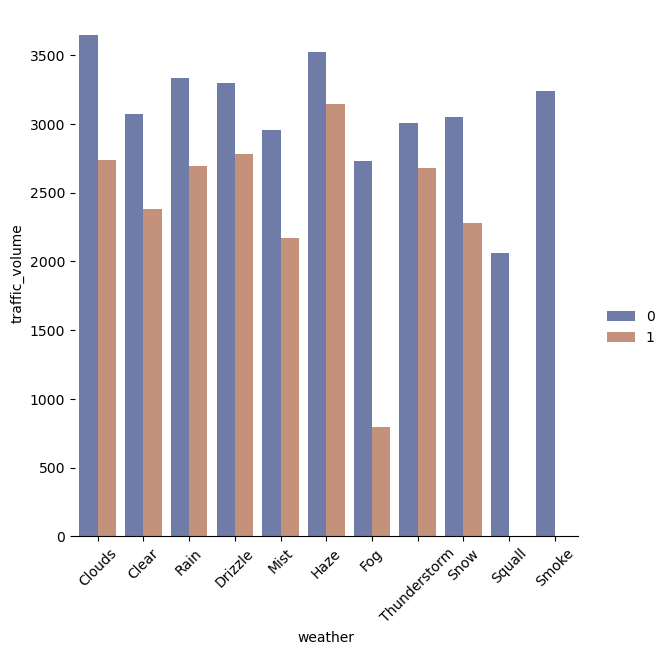

In [14]:
import seaborn as sns
g = sns.catplot(
    data=df, kind="bar",
    x="weather_main", y="traffic_volume", hue="is_holiday",
    errorbar=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("weather", "traffic_volume")
g.legend.set_title("")
plt.xticks(rotation=45)
plt.show()

In [15]:
# frequency of the values in different categorical columns 
print('WEATHER_MAIN')
print(df['weather_main'].value_counts().sort_values(ascending=False))

print('---'*20)
print('WEATHER DESCRIPTION')
print(df['weather_description'].value_counts().sort_values(ascending=False))

WEATHER_MAIN
Clouds          15159
Clear           13384
Mist             5950
Rain             5671
Snow             2876
Drizzle          1821
Haze             1359
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64
------------------------------------------------------------
WEATHER DESCRIPTION
sky is clear                           11658
mist                                    5950
overcast clouds                         5081
broken clouds                           4665
scattered clouds                        3458
light rain                              3371
few clouds                              1955
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1359
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
d

In [16]:
#example of weather description for Cloud weather
df[df['weather_main']=='Clouds'].groupby('weather_description')['date_time'].count()

weather_description
broken clouds       4665
few clouds          1955
overcast clouds     5081
scattered clouds    3458
Name: date_time, dtype: int64

In [17]:
# Categorical features
print(df.dtypes=='object')

holiday                 True
temp                   False
rain_1h                False
snow_1h                False
clouds_all             False
weather_main            True
weather_description     True
date_time               True
traffic_volume         False
is_holiday             False
dtype: bool


<Axes: xlabel='temp', ylabel='Count'>

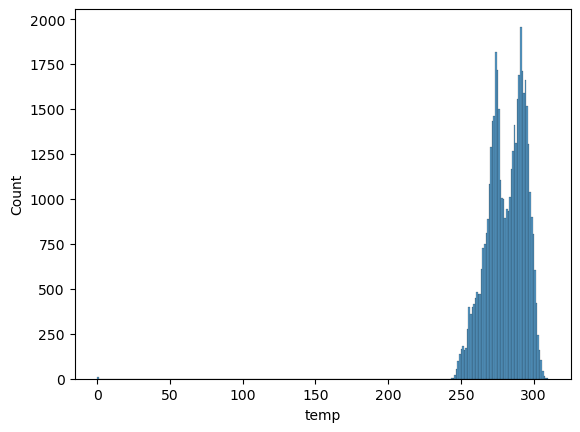

In [18]:
sns.histplot(df['temp'])

## There are some error, there temp is 0K, dream of all physicist

<Axes: xlabel='temp', ylabel='Count'>

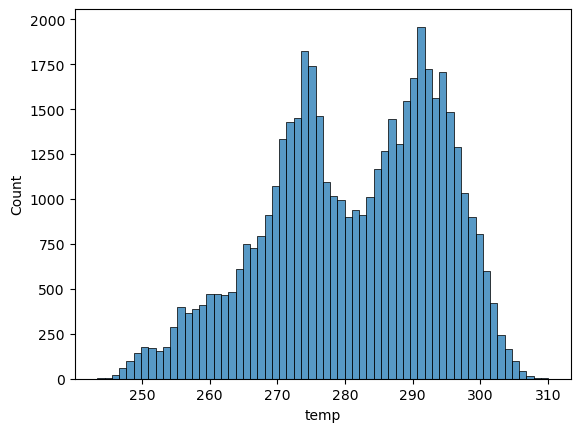

In [19]:
df.drop(df[df['temp']<200].index,inplace=True)
sns.histplot(df['temp'])

# New columns

In [199]:
#  `temp_in_celcius` column from the existing `temp` (kelvin
df['temp_in_celcius'] = df['temp'] - 273
# bool column `hot` which indicates whether the time slot was hot (temp_celsius > 27)
df['hot'] = df['temp_in_celcius'].apply(lambda x: 1*(x>27))
# bool column `hot` which indicates whether the time slot was cold (temp_celsius > 27)
df['cold'] = df['temp_in_celcius'].apply(lambda x: 1*(x<-10))
# bool column `rainy_and_cloudy` which indicates whether it was rainy (>0.1) AND cloudy (>50)
df['rainy_and_cloudy'] = df[['rain_1h','clouds_all']].apply(lambda x: 1*((x[0]>0.1 and x[1]>50)),axis=1)


# new column `traffic_cat` by splitting a `traffic_volume` into 5 ([1..5]) distinct intervals: 0 < x <=20%,
# 20% < x <= 40%, ... 80% < x <= 100% percentiles. You could use `.quantile()` to compute percentiles.
quant_lvl = list(df['traffic_volume'].quantile([0.2,0.4,0.6,0.8,1]))
def cat(x):
    lvl = quant_lvl
    i=0
    while x>lvl[i]:
        i+=1
    return i+1
df['traffic_cat'] = df['traffic_volume'].apply(cat)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,is_holiday,temp_in_celcius,hot,cold,rainy_and_cloudy,traffic_cat,weekday,hour,month,year
0,None,288.28,0.0,0.0,40.0,Clouds,scattered clouds,2012-10-02 09:00:00,5545.0,0,15.28,0,0,0,5,1,9,10,2012
1,None,289.36,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 10:00:00,4516.0,0,16.36,0,0,0,4,1,10,10,2012
2,None,289.58,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 11:00:00,4767.0,0,16.58,0,0,0,4,1,11,10,2012
3,None,290.13,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 12:00:00,5026.0,0,17.13,0,0,0,4,1,12,10,2012
4,None,291.14,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 13:00:00,4918.0,0,18.14,0,0,0,4,1,13,10,2012


# Data observation by time

In [200]:
#hour,weekday,month feature
df['weekday'] = pd.to_datetime(df['date_time']).dt.weekday
df['hour'] = pd.to_datetime(df['date_time']).dt.hour
df['month'] = pd.to_datetime(df['date_time']).dt.month
df['year'] = pd.to_datetime(df['date_time']).dt.year

Text(0.5, 1.0, 'By weekday')

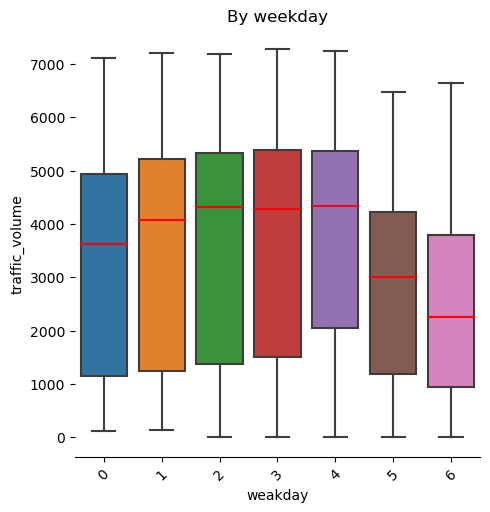

In [201]:
g = sns.catplot(
    data=df, kind="box",
    x="weekday", y="traffic_volume", medianprops={'color':'red'})
g.despine(left=True)
g.set_axis_labels("weakday", "traffic_volume")
plt.xticks(rotation=45)
plt.title('By weekday')


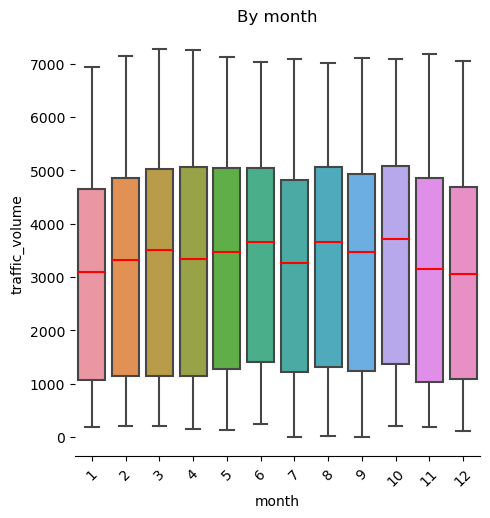

In [202]:
g = sns.catplot(
    data=df, kind="box",
    x="month", y="traffic_volume", medianprops={'color':'red'})
g.despine(left=True)
g.set_axis_labels("month", "traffic_volume")
plt.xticks(rotation=45)
plt.title('By month')
plt.show();

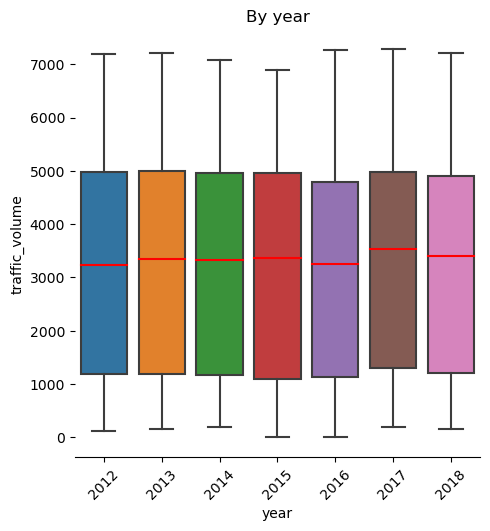

In [203]:
g = sns.catplot(
    data=df, kind="box",
    x="year", y="traffic_volume", medianprops={'color':'red'})
g.despine(left=True)
g.set_axis_labels("year", "traffic_volume")
plt.xticks(rotation=45)
plt.title('By year')
plt.show();

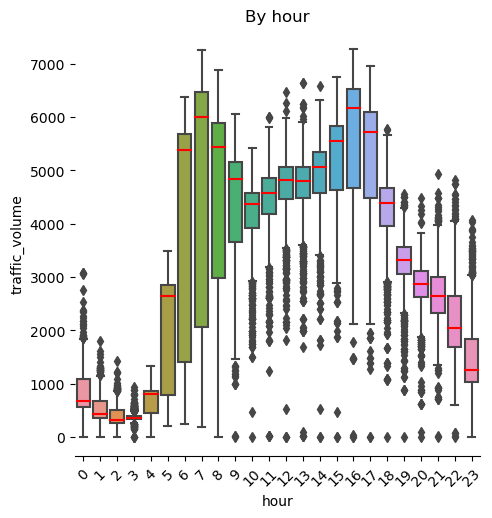

In [204]:
g = sns.catplot(
    data=df, kind="box",
    x="hour", y="traffic_volume", medianprops={'color':'red'})
g.despine(left=True)
g.set_axis_labels("hour", "traffic_volume")
plt.xticks(rotation=45)
plt.title('By hour')
plt.show();

# Building a regression model




1. Train on [0], test on [1]
2. Train on [0,1], test on [2]
3. Train on [0, 1, 2], test on [3]
4. Train on [0, 1, 2, 3], test on [4]


In [213]:
from sklearn.preprocessing import OneHotEncoder

ohe=OneHotEncoder(sparse_output=False)

categorical_columns = ['weather_main','weather_description','is_holiday','hot','cold','rainy_and_cloudy',
                       'weekday','hour','month','year']

encoded_features = pd.DataFrame(ohe.fit_transform(df[categorical_columns]))

In [214]:
names = ohe.get_feature_names_out(categorical_columns)

In [215]:
df_cat = encoded_features.set_axis(names,axis=1)

In [216]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_columns = ['rain_1h','snow_1h','clouds_all','temp_in_celcius']
df_num = pd.DataFrame(scaler.fit_transform(df[num_columns]),columns=num_columns)

In [217]:
X = pd.concat([df_num,df_cat],axis=1, join="inner")

In [218]:
X

,rain_1h,snow_1h,clouds_all,temp_in_celcius,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,...,month_10,month_11,month_12,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,0.0,0.0,0.40,0.673215,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.75,0.689412,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.90,0.692711,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.90,0.700960,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.75,0.716107,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48175,0.0,0.0,0.75,0.600780,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
48176,0.0,0.0,0.90,0.590432,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
48177,0.0,0.0,0.90,0.589982,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
48178,0.0,0.0,0.90,0.580384,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [219]:
y = df['traffic_volume']
y_cat = df['traffic_cat'] # for classification task

## Feature selection

## K-Best based

In [220]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

columns = X.columns
sel_kBest_f = SelectKBest(f_regression, k=30)
#sel_kBest_MIR = SelectKBest(mutual_info_regression, k=40) takes to many time to compute for 122 feature

X_kBest_f = sel_kBest_f.fit_transform(X, y)

In [115]:
k_best_names = sel_kBest_f.get_feature_names_out(X.columns)
print(k_best_names)
X_kBest = X[k_best_names]

['temp_in_celcius' 'weather_main_Clouds'
 'weather_description_scattered clouds' 'hot_0' 'hot_1' 'weekday_3'
 'weekday_4' 'weekday_5' 'weekday_6' 'hour_0' 'hour_1' 'hour_2' 'hour_3'
 'hour_4' 'hour_5' 'hour_6' 'hour_7' 'hour_8' 'hour_9' 'hour_10' 'hour_11'
 'hour_12' 'hour_13' 'hour_14' 'hour_15' 'hour_16' 'hour_17' 'hour_18'
 'hour_22' 'hour_23']


# Lasso based

In [35]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
lasso = LassoCV(cv=10)
lasso.fit(X,y)
coef_abs = np.abs(lasso.coef_)
feature_idx = np.argsort(coef_abs)[::-1][:30]
selected_features = columns[feature_idx]

In [36]:
selected_features

Index(['hour_3', 'hour_2', 'hour_1', 'hour_4', 'hour_0', 'hour_23', 'hour_5',
       'hour_22', 'hour_21', 'hour_16', 'hour_20', 'weekday_6', 'hour_17',
       'hour_15', 'is_holiday_0', 'hour_19', 'weekday_5', 'hour_14', 'hour_7',
       'hour_12', 'hour_13', 'hour_8', 'temp_in_celcius', 'hour_11',
       'weather_description_snow', 'hour_9', 'month_7', 'month_12',
       'weekday_4', 'weekday_3'],
      dtype='object')

In [37]:
X_lasso = X[selected_features]

## Train/Test

In [38]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

tss = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tss.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [   0    1    2 ... 8027 8028 8029] TEST: [ 8030  8031  8032 ... 16057 16058 16059]
TRAIN: [    0     1     2 ... 16057 16058 16059] TEST: [16060 16061 16062 ... 24087 24088 24089]
TRAIN: [    0     1     2 ... 24087 24088 24089] TEST: [24090 24091 24092 ... 32117 32118 32119]
TRAIN: [    0     1     2 ... 32117 32118 32119] TEST: [32120 32121 32122 ... 40147 40148 40149]
TRAIN: [    0     1     2 ... 40147 40148 40149] TEST: [40150 40151 40152 ... 48177 48178 48179]


In [54]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import time

lasso_param_grid = {'alpha':np.linspace(0.01,5,40)}

ridge_param_grid = {'alpha':[.1,.3,.5,1,2,3,4,5,10],
                   'solver':['auto', 'svd', 'lsqr']}

RFR_param_grid  = {'n_estimators':[100,200],
                  'max_depth':[None,10,25]}

KNR_param_grid = {'n_neighbors':[10,20,30],
                 'algorithm':['auto', 'kd_tree']}

DTR_param_grid = {'max_depth': [i for i in range(5,50,5)]}

lasso = Lasso()
ridge = Ridge()
RFR = RandomForestRegressor()
KNR = KNeighborsRegressor()
DTR = DecisionTreeRegressor()

def get_cv_scores(model,X,y,param_grid,name):
    grid_search = GridSearchCV(model, param_grid = param_grid, cv=tss, scoring='r2')
    grid_search.fit(X,y)
    score = grid_search.best_score_
    params_res = grid_search.best_params_
    print(name)
    print(score)
    print(params_res)
    return score, params_res
    
print('R^2 Lasso Based')

grids = [lasso_param_grid,ridge_param_grid, RFR_param_grid, KNR_param_grid, DTR_param_grid]
models = [lasso, ridge, RFR, KNR, DTR]
names = ['Lasso', 'Ridge', 'RandomForestRegressor', 'KNeighborsRegressor', 'DecisionTreeRegressor']

scores_lasso = []
params_lasso = []
time_lst = []

for param,model,name in zip(grids,models,names):
    start = time.time()
    print('---'*7)
    res = get_cv_scores(model,X_lasso,y,param,name)
    scores_lasso.append(res[0])
    params_lasso.append(res[1])
    end = time.time()
    time_lst.append(end-start)
    print('Time:',end-start)

R^2 Lasso Based
---------------------
Lasso
0.8349645427038064
{'alpha': 0.6497435897435898}
Time: 6.991946697235107
---------------------
Ridge
0.8349148416495602
{'alpha': 2, 'solver': 'lsqr'}
Time: 3.879809617996216
---------------------
RandomForestRegressor
0.9182984178555925
{'max_depth': 25, 'n_estimators': 200}
Time: 407.94666743278503
---------------------
KNeighborsRegressor
0.9192153811456947
{'algorithm': 'auto', 'n_neighbors': 10}
Time: 94.15389561653137
---------------------
DecisionTreeRegressor
0.9048673335046455
{'max_depth': 20}
Time: 4.418219566345215


In [55]:
print('R^2 kBest Based')
scores_kBest = []
params_kBest = []

for param,model,name in zip(grids,models,names):
    start = time.time()
    print('---'*7)
    res = get_cv_scores(model,X_kBest,y,param,name)
    scores_kBest.append(res[0])
    params_kBest.append(res[1])
    end = time.time()
    time_lst.append(end-start)
    print('Time:',end-start)

R^2 kBest Based
---------------------
Lasso
0.8232521615064077
{'alpha': 1.1615384615384616}
Time: 8.06240200996399
---------------------
Ridge
0.8231493495397979
{'alpha': 10, 'solver': 'auto'}
Time: 5.216373920440674
---------------------
RandomForestRegressor
0.9108751871085786
{'max_depth': 25, 'n_estimators': 200}
Time: 403.29882884025574
---------------------
KNeighborsRegressor
0.9175733249507283
{'algorithm': 'auto', 'n_neighbors': 20}
Time: 116.75669860839844
---------------------
DecisionTreeRegressor
0.8810359461591524
{'max_depth': 25}
Time: 4.9670281410217285


In [221]:
import warnings
warnings.filterwarnings('ignore')

grids = [lasso_param_grid,ridge_param_grid, RFR_param_grid, KNR_param_grid, DTR_param_grid]
models = [lasso, ridge, RFR, KNR, DTR]
names = ['Lasso', 'Ridge', 'RandomForestRegressor', 'KNeighborsRegressor', 'DecisionTreeRegressor']

print('R^2 No selection')
scores_no_fs = []
params_no_fs = []

for param,model,name in zip(grids,models,names):
    start = time.time()
    print('---'*7)
    res = get_cv_scores(model,X,y,param,name)
    scores_no_fs.append(res[0])
    params_no_fs.append(res[1])
    end = time.time()
    time_lst.append(end-start)
    print('Time:',end-start)

R^2 No selection
---------------------
Lasso
0.8342423216675373
{'alpha': 2.568974358974359}
Time: 84.89672183990479
---------------------
Ridge
0.8319725078710023
{'alpha': 10, 'solver': 'auto'}
Time: 23.112242698669434
---------------------
RandomForestRegressor
0.9459692113278388
{'max_depth': 25, 'n_estimators': 100}
Time: 1088.0082867145538
---------------------
KNeighborsRegressor
0.5893238944374283
{'algorithm': 'auto', 'n_neighbors': 5}
Time: 326.5196723937988
---------------------
DecisionTreeRegressor
0.9302245710055328
{'max_depth': 20}
Time: 14.81476092338562


In [222]:
scores = scores_lasso + scores_kBest + scores_no_fs
models = names + names + names
feature_selection = ['lasso']*5 + ['kBest']*5 + ['no_feat_select']*5

In [228]:
df_fs = pd.DataFrame({'R^2':scores,'name':models,'feature_selection':feature_selection})
df_fs

,R^2,name,feature_selection
0,0.834965,Lasso,lasso
1,0.834915,Ridge,lasso
2,0.918298,RandomForestRegressor,lasso
3,0.919215,KNeighborsRegressor,lasso
4,0.904867,DecisionTreeRegressor,lasso
5,0.823252,Lasso,kBest
6,0.823149,Ridge,kBest
7,0.910875,RandomForestRegressor,kBest
8,0.917573,KNeighborsRegressor,kBest
9,0.881036,DecisionTreeRegressor,kBest


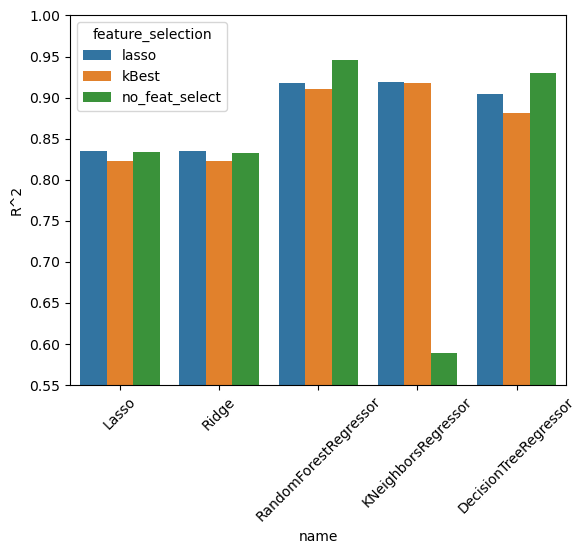

In [231]:
sns.barplot(data=df_fs,x='name',y='R^2',hue='feature_selection')
plt.xticks(rotation=45)
plt.ylim(0.55, 1)
plt.show()

for all models Lasso feature selection gave better results than kBest. Feature selection doesn't give growth of score, especially for decision tree (score downgraded), but it accelerates calculation for many time. For KNR model, because of curse of dimensionality, no feature selection model performs much worse

In [77]:
def SelectLasso(X,y,num=10):
    lasso = LassoCV(cv=10)
    lasso.fit(X,y)
    coef_abs = np.abs(lasso.coef_)
    feature_idx = np.argsort(coef_abs)[::-1][:num]
    selected_features = columns[np.unique(feature_idx)]
    return X[selected_features], y

In [178]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

scores_xgb_lasso = []
params_xgb_lasso = []
time_xgb_lasso = []


feature_nums = [i for i in range(10,120,10)]
xgb = xgb.XGBRegressor()

XGB_param_grid = params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

def get_cv_scores_random(model,X,y,param_grid,name,scoring='r2'):
    grid_search = RandomizedSearchCV(model, param_distributions = param_grid, cv=tss, scoring='r2',n_iter=9)
    grid_search.fit(X,y)
    score = grid_search.best_score_
    params_res = grid_search.best_params_
    print(name)
    print(score)
    print(params_res)
    return score, params_res

In [180]:
for i in feature_nums:
    start = time.time()
    print('---'*7)
    print('num_features:',i)
    X_i, y_i = SelectLasso(X,y,i)
    res = get_cv_scores_random(xgb,X_i,y_i,XGB_param_grid,'XGB')
    scores_xgb_lasso.append(res[0])
    params_xgb_lasso.append(res[1])
    end = time.time()
    time_xgb_lasso.append(end-start)
    print('Time:',end-start)

---------------------
num_features: 10
XGB
0.7131217849190647
{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.6}
Time: 41.9804892539978
---------------------
num_features: 20
XGB
0.9027323674425147
{'subsample': 0.6, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 0.5, 'colsample_bytree': 0.8}
Time: 48.02964520454407
---------------------
num_features: 30
XGB
0.9212820550418644
{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 1.0}
Time: 65.79003763198853
---------------------
num_features: 40
XGB
0.9191286531724439
{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
Time: 73.15975642204285
---------------------
num_features: 50
XGB
0.9201022874958518
{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.8}
Time: 82.03384280204773
---------------------
num_features: 60
XGB
0.919403351132501
{'subsample': 0.6, 'min_ch

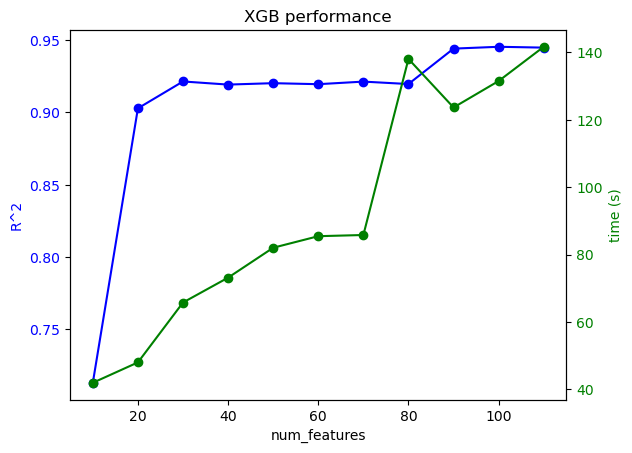

In [190]:
fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel('num_features')
ax1.set_ylabel('R^2', color = color)
ax1.plot(feature_nums, scores_xgb_lasso, color = color,marker='o')
ax1.tick_params(axis ='y', labelcolor = color)
   
ax2 = ax1.twinx()
   
color = 'green'
ax2.set_ylabel('time (s)', color = color)
ax2.plot(feature_nums, time_xgb_lasso, marker='o',color = color)
ax2.tick_params(axis ='y', labelcolor = color)
  
plt.title('XGB performance')
plt.show()

In [232]:
def get_cv_scores_random(model,X,y,param_grid,name,scoring='r2'):
    grid_search = RandomizedSearchCV(model, param_distributions = param_grid, cv=tss, scoring=scoring,n_iter=9)
    grid_search.fit(X,y)
    score = grid_search.best_score_
    params_res = grid_search.best_params_
    print(name)
    print(score)
    print(params_res)
    return score, params_res

xgb_mse_score = []
time_xgb_mse = []
params_xgb_mse = []

for i in feature_nums:
    start = time.time()
    print('---'*7)
    print('num_features:',i)
    X_i, y_i = SelectLasso(X,y,i)
    res = get_cv_scores_random(xgb,X_i,y_i,XGB_param_grid,'XGB',scoring='neg_mean_squared_error')
    xgb_mse_score.append(res[0])
    params_xgb_mse.append(res[1])
    end = time.time()
    time_xgb_mse.append(end-start)
    print('Time:',end-start)


---------------------
num_features: 10
XGB
-1120634.2967147913
{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 0.5, 'colsample_bytree': 1.0}
Time: 35.20141315460205
---------------------
num_features: 20
XGB
-376456.4963141691
{'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 5, 'colsample_bytree': 1.0}
Time: 52.94738006591797
---------------------
num_features: 30
XGB
-314172.2691350163
{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 0.5, 'colsample_bytree': 1.0}
Time: 66.21245408058167
---------------------
num_features: 40
XGB
-312047.99556948466
{'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 0.5, 'colsample_bytree': 0.6}
Time: 75.05686902999878
---------------------
num_features: 50
XGB
-306133.64884075226
{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 0.5, 'colsample_bytree': 0.8}
Time: 89.39479327201843
---------------------
num_features: 60
XGB
-312578.1375506637
{'subsample': 0.8, '

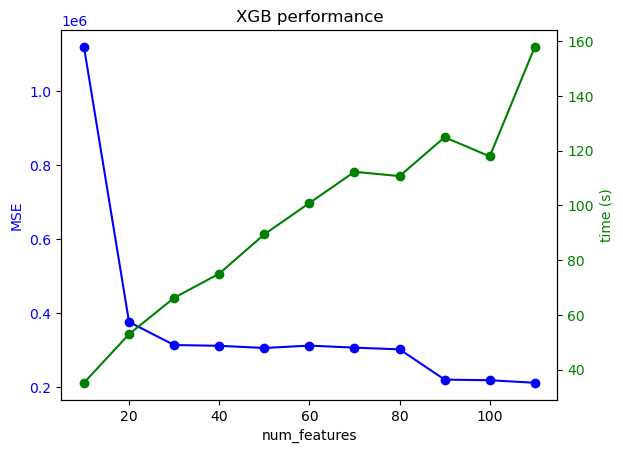

In [234]:
fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel('num_features')
ax1.set_ylabel('MSE', color = color)
ax1.plot(feature_nums, np.abs(xgb_mse_score), color = color,marker='o')
ax1.tick_params(axis ='y', labelcolor = color)
   
ax2 = ax1.twinx()
   
color = 'green'
ax2.set_ylabel('time (s)', color = color)
ax2.plot(feature_nums, time_xgb_mse, marker='o',color = color)
ax2.tick_params(axis ='y', labelcolor = color)
  
plt.title('XGB performance')
plt.show()